# PROJECT 2 : RECOMMENDATION SYSTEM (INSIGHTS + CONTENT-BASED FILTERING)

## Import libraries

In [ ]:
!pip install numpy==1.23.5

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import warnings
import re
import time

In [ ]:
# print(pd.__version__)

In [ ]:
# print(np.__version__)

In [ ]:
!pip install gensim
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatibl

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
STOP_WORD_FILE = '/content/gdrive/MyDrive/Do_An_TN/vietnamese-stopwords.txt'

## Load data and Pre-processing

In [ ]:
file_1 = pd.read_csv("/content/gdrive/MyDrive/Do_An_TN/Products_ThoiTrangNam_raw.csv")
file_1.head()

,product_id,product_name,category,sub_category,link,image,price,rating,description
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,https://cf.shopee.vn/file/2c1ca03f5dc42f316fdf...,86250.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,https://cf.shopee.vn/file/c7ea4c6574dc79be6b26...,26800.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,https://cf.shopee.vn/file/6f93bcda10efe374f8cc...,39500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,https://cf.shopee.vn/file/1d7ed5e34bff8bc8b49a...,16500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,NaN,45000.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...


In [ ]:
file_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49663 entries, 0 to 49662
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_id    49663 non-null  int64  
 1   product_name  49663 non-null  object 
 2   category      49663 non-null  object 
 3   sub_category  49663 non-null  object 
 4   link          49663 non-null  object 
 5   image         36443 non-null  object 
 6   price         49663 non-null  float64
 7   rating        49663 non-null  float64
 8   description   48700 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 3.4+ MB


In [ ]:
# Check for missing values
file_1.isnull().sum()

,0
product_id,0
product_name,0
category,0
sub_category,0
link,0
image,13220
price,0
rating,0
description,963


In [ ]:
file_1.duplicated().sum()

0

In [ ]:
# Drop unnecessary columns
file_1_n = file_1.drop(columns=['image'])
file_1_n.head()

,product_id,product_name,category,sub_category,link,price,rating,description
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,86250.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,26800.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,39500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,16500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,45000.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...


In [ ]:
file_2 = pd.read_csv("/content/gdrive/MyDrive/Do_An_TN/Products_ThoiTrangNam_rating_raw.csv", sep='\t')
file_2.head()

,product_id,user_id,user,rating
0,190,1,karmakyun2nd,5
1,190,2,tranquangvinh_vv,5
2,190,3,nguyenquoctoan2005,5
3,190,4,nguyenthuyhavi,5
4,190,5,luonganh5595,5


In [ ]:
file_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024482 entries, 0 to 1024481
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   product_id  1024482 non-null  int64 
 1   user_id     1024482 non-null  int64 
 2   user        1024482 non-null  object
 3   rating      1024482 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 31.3+ MB


In [ ]:
# Check for missing values
file_2.isnull().sum()

,0
product_id,0
user_id,0
user,0
rating,0


In [ ]:
file_2.duplicated().sum()

24667

In [ ]:
file_2.drop_duplicates(inplace=True)
file_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 999815 entries, 0 to 1024481
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   product_id  999815 non-null  int64 
 1   user_id     999815 non-null  int64 
 2   user        999815 non-null  object
 3   rating      999815 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 38.1+ MB


## Insights

### Products (file_1)

In [ ]:
file_1.head()

,product_id,product_name,category,sub_category,link,image,price,rating,description
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,https://cf.shopee.vn/file/2c1ca03f5dc42f316fdf...,86250.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,https://cf.shopee.vn/file/c7ea4c6574dc79be6b26...,26800.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,https://cf.shopee.vn/file/6f93bcda10efe374f8cc...,39500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,https://cf.shopee.vn/file/1d7ed5e34bff8bc8b49a...,16500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,NaN,45000.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...


In [ ]:
print('Number of unique values:')
for col in file_1.columns:
  print(col, ':', file_1[col].nunique())

Number of unique values:
product_id : 49653
product_name : 47103
category : 1
sub_category : 17
link : 49653
image : 35191
price : 7792
rating : 31
description : 45071


- Có tất cả 49653 sản phẩm thuộc 17 sub-cat

In [ ]:
# Chuyển đổi tiền
def format_currency(value):
  if pd.isna(value):
    return None
  return f'{value:,.0f}'

In [ ]:
# Thống kê giá sản phẩm
cat_price = file_1.groupby('sub_category').agg(avg_price=('price', 'mean'), avg_rating=('rating', 'mean')).sort_values(by='avg_price', ascending=False)
cat_price

,avg_price,avg_rating
sub_category,,
Áo Vest và Blazer,517250.890396,2.803592
Trang Phục Truyền Thống,400608.279608,1.080431
Đồ Hóa Trang,379889.666463,1.297859
Đồ Ngủ,296849.875000,1.095000
Khác,286988.103759,3.053328
Kính Mắt Nam,280363.648339,2.075777
Áo Khoác,242987.880864,4.811914
Quần Jeans,216218.479333,4.841467
"Áo Hoodie, Áo Len & Áo Nỉ",190409.204000,4.790267


In [ ]:
# Format price
cat_price['avg price'] = cat_price['avg_price'].apply(format_currency)
cat_price[['avg price', 'avg_rating']]

,avg price,avg_rating
sub_category,,
Áo Vest và Blazer,"517,251",2.803592
Trang Phục Truyền Thống,"400,608",1.080431
Đồ Hóa Trang,"379,890",1.297859
Đồ Ngủ,"296,850",1.095000
Khác,"286,988",3.053328
Kính Mắt Nam,"280,364",2.075777
Áo Khoác,"242,988",4.811914
Quần Jeans,"216,218",4.841467
"Áo Hoodie, Áo Len & Áo Nỉ","190,409",4.790267


- Áo Vest và Blazer có giá trung bình cao nhất

<ipython-input-21-875fc2e1c63b>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(cat_price, y='avg_price', x='sub_category', palette='viridis', ci=None)
<ipython-input-21-875fc2e1c63b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(cat_price, y='avg_price', x='sub_category', palette='viridis', ci=None)


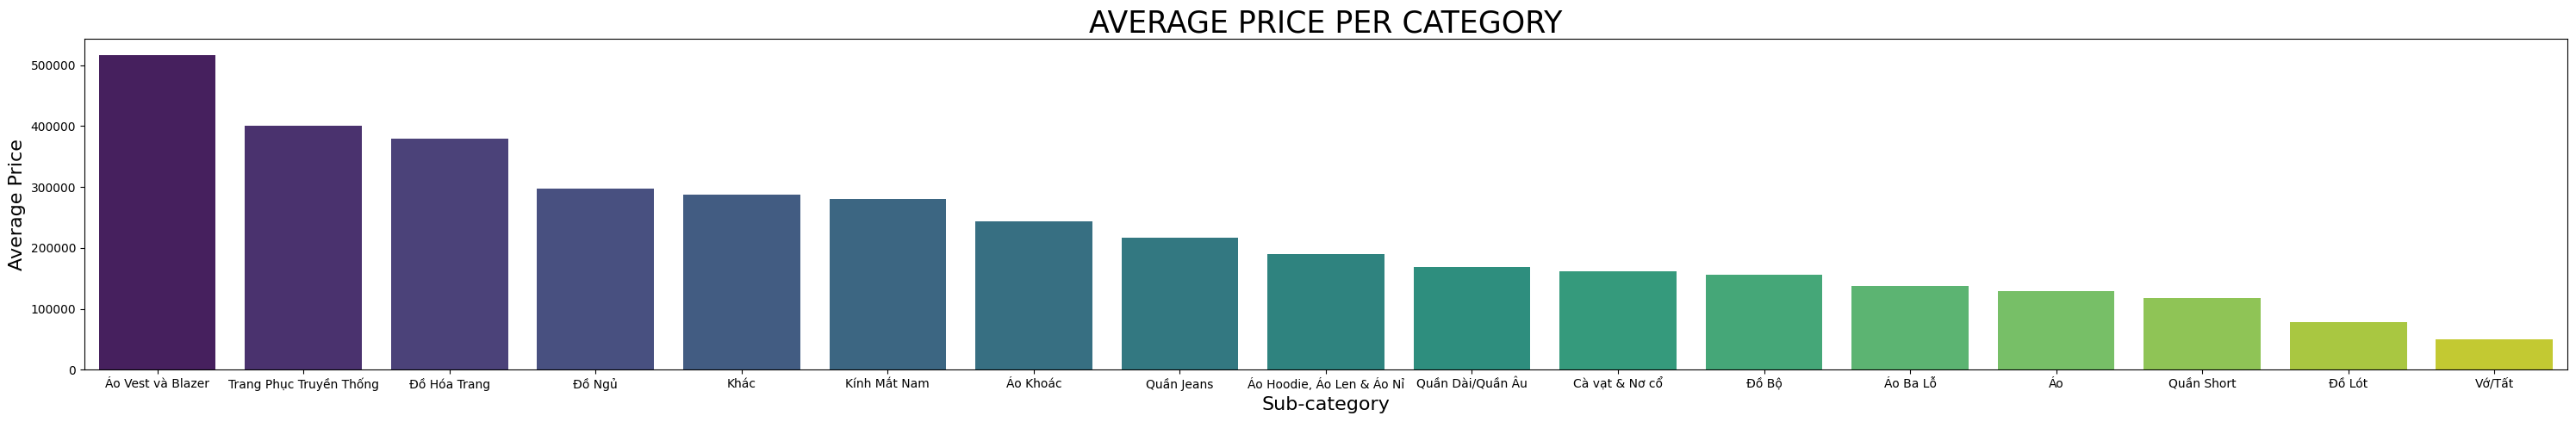

In [ ]:
plt.figure(figsize=(30,5))
sns.barplot(cat_price, y='avg_price', x='sub_category', palette='viridis', ci=None)
plt.xlabel('Sub-category', fontsize=16)
plt.ylabel('Average Price', fontsize=16)
plt.title('AVERAGE PRICE PER CATEGORY', fontsize=25)
plt.tight_layout()
plt.show()

<ipython-input-22-2c7c7446df55>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(cat_price.sort_values(by='avg_rating', ascending=False), y='avg_rating', x='sub_category', palette='viridis', ci=None)
<ipython-input-22-2c7c7446df55>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(cat_price.sort_values(by='avg_rating', ascending=False), y='avg_rating', x='sub_category', palette='viridis', ci=None)


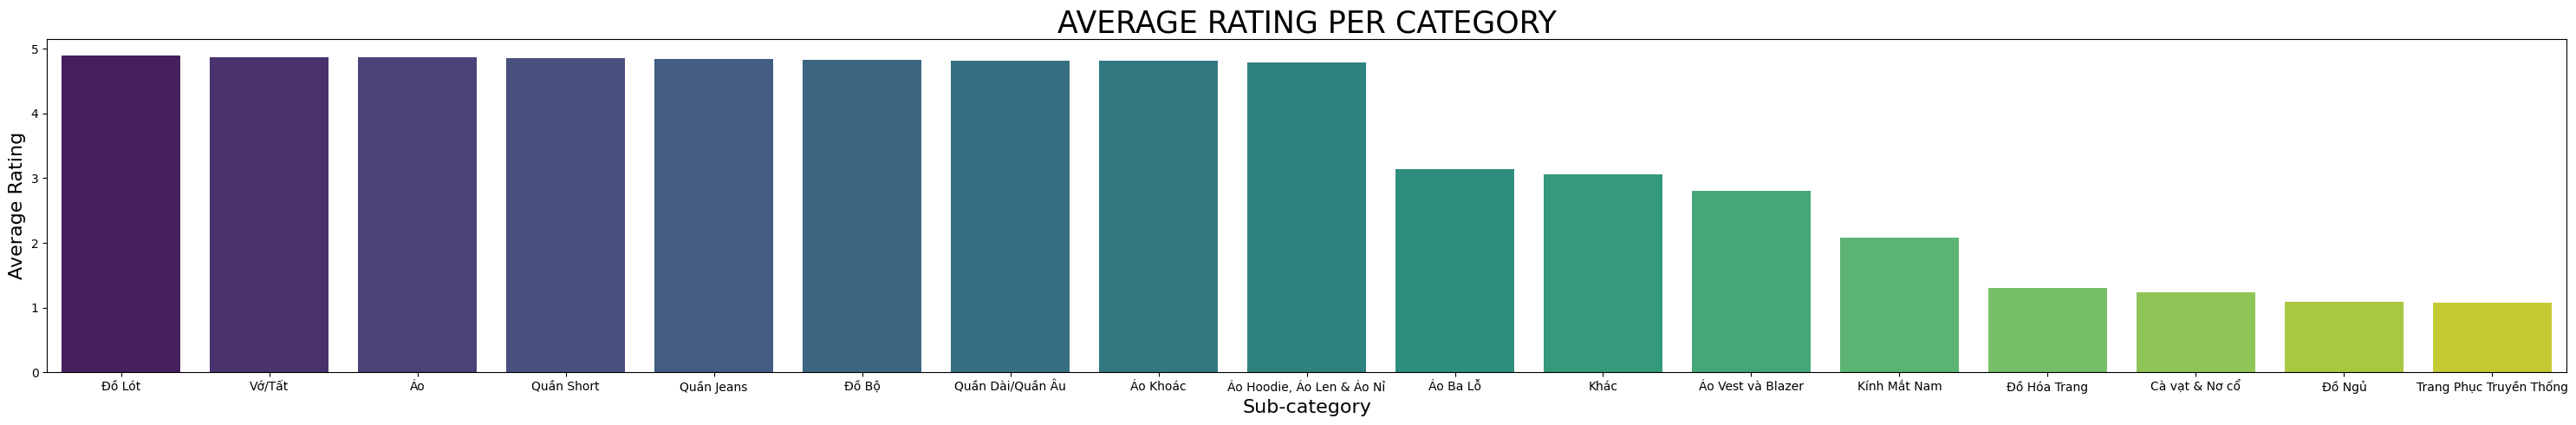

In [ ]:
plt.figure(figsize=(30,5))
sns.barplot(cat_price.sort_values(by='avg_rating', ascending=False), y='avg_rating', x='sub_category', palette='viridis', ci=None)
plt.xlabel('Sub-category', fontsize=16)
plt.ylabel('Average Rating', fontsize=16)
plt.title('AVERAGE RATING PER CATEGORY', fontsize=25)
plt.tight_layout()
plt.show()

### Reviews (file_2 + file_1)

#### Review file_2

In [ ]:
print('Number of unique values:')
for col in file_2.columns:
  print(col, ':', file_2[col].nunique())

Number of unique values:
product_id : 31267
user_id : 650636
user : 650636
rating : 5


- Có 650636 users, thực hiện review cho tổng cộng 31267 sản phẩm

In [ ]:
file_2.head(5)

,product_id,user_id,user,rating
0,190,1,karmakyun2nd,5
1,190,2,tranquangvinh_vv,5
2,190,3,nguyenquoctoan2005,5
3,190,4,nguyenthuyhavi,5
4,190,5,luonganh5595,5


#### Review file_2 + file_1

In [ ]:
df = pd.merge(file_2, file_1[['product_id',	'product_name',	'price', 'sub_category']], on='product_id', how='inner')
df.head()

,product_id,user_id,user,rating,product_name,price,sub_category
0,190,1,karmakyun2nd,5,"Áo ba lỗ thun gân ,form body tôn dáng",86250.0,Áo Ba Lỗ
1,190,2,tranquangvinh_vv,5,"Áo ba lỗ thun gân ,form body tôn dáng",86250.0,Áo Ba Lỗ
2,190,3,nguyenquoctoan2005,5,"Áo ba lỗ thun gân ,form body tôn dáng",86250.0,Áo Ba Lỗ
3,190,4,nguyenthuyhavi,5,"Áo ba lỗ thun gân ,form body tôn dáng",86250.0,Áo Ba Lỗ
4,190,5,luonganh5595,5,"Áo ba lỗ thun gân ,form body tôn dáng",86250.0,Áo Ba Lỗ


In [ ]:
df.shape

(994751, 7)

In [ ]:
# Check for missing values
df.isnull().sum()

,0
product_id,0
user_id,0
user,0
rating,0
product_name,0
price,0
sub_category,0


In [ ]:
cat_cols = df.select_dtypes('object').columns
cat_cols

Index(['user', 'product_name', 'sub_category'], dtype='object')

In [ ]:
df[cat_cols].describe()

,user,product_name,sub_category
count,994751,994751,994751
unique,647647,30365,17
top,Người dùng Shopee,Áo chống nắng thông hơi nam phiên bán cải tiến...,Đồ Bộ
freq,12951,532,196135


- Có 647647 users, với tổng cộng 994751 lượt mua
- User có tên 'Người dùng Shopee' đứng top 1 mua hàng với tổng lượt mua là 12,951
- Sản phẩm 'Áo chống nắng thông hơ nam phiên bản cải tiến' được reviews nhiều nhất với 532 lượt
- Phân loại hàng 'Đồ bộ' là sản phẩm được mua nhiều nhất với tổng lượt mua là 196,135 lượt mua

In [ ]:
# Total reviews of each products
count_reviews = df.groupby('product_name').agg(count_no_reviews=('rating', 'count')).sort_values(by='count_no_reviews', ascending=False)
count_reviews

,count_no_reviews
product_name,
Áo chống nắng thông hơi nam phiên bán cải tiến mới nhất,532
Áo khoác Bomber dù Unisex Ulzzang nam nữ Nhiều Mẫu Hot Áo Bomber dù 2 lớp lên from mặc siêu đẹp Zalofa,528
Hộp 10 đôi tất chống hôi chân hàng xuất Nhật ( Hàng Xịn Đẹp) BT01,508
"Áo khoác gió nam 2 lớp chống nước 2021 , chất gió tráng bạc, chống mưa, chống gió, ngăn tia UV tuyệt đối",508
"Áo khoác nam nữ unisex 2 lớp chống nước cao cấp, áo gió nam nữ mẫu mới siêu hot 2021 - ZATA VN",486
...,...
Áo Thun Tay lỡ 💖𝑭𝑹𝑬?𝑺𝑯𝑰𝑷 💖 Áo thun Mèo Ami Bụng Bự L 86,1
Áo Thun Tay Ngắn Thời Trang Dành Cho Nam,1
Áo Thun Tay Ngắn In Hình Thời Trang Trẻ Trung,1


In [ ]:
# Top 5 Number of Reviews per Product
top_5_reviews = count_reviews.sort_values(by='count_no_reviews', ascending=False).head(5)

- Áo chống nắng thông hơi nam phiên bản cải tiến mới nhất là sản phẩm có nhiều lượt đánh giá từ KH đã mua nhất

<ipython-input-35-1e3e1458017b>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(count_reviews.sort_values(by='count_no_reviews', ascending=False).head(5), y='count_no_reviews', x='product_name', palette='viridis', ci=None)
<ipython-input-35-1e3e1458017b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(count_reviews.sort_values(by='count_no_reviews', ascending=False).head(5), y='count_no_reviews', x='product_name', palette='viridis', ci=None)


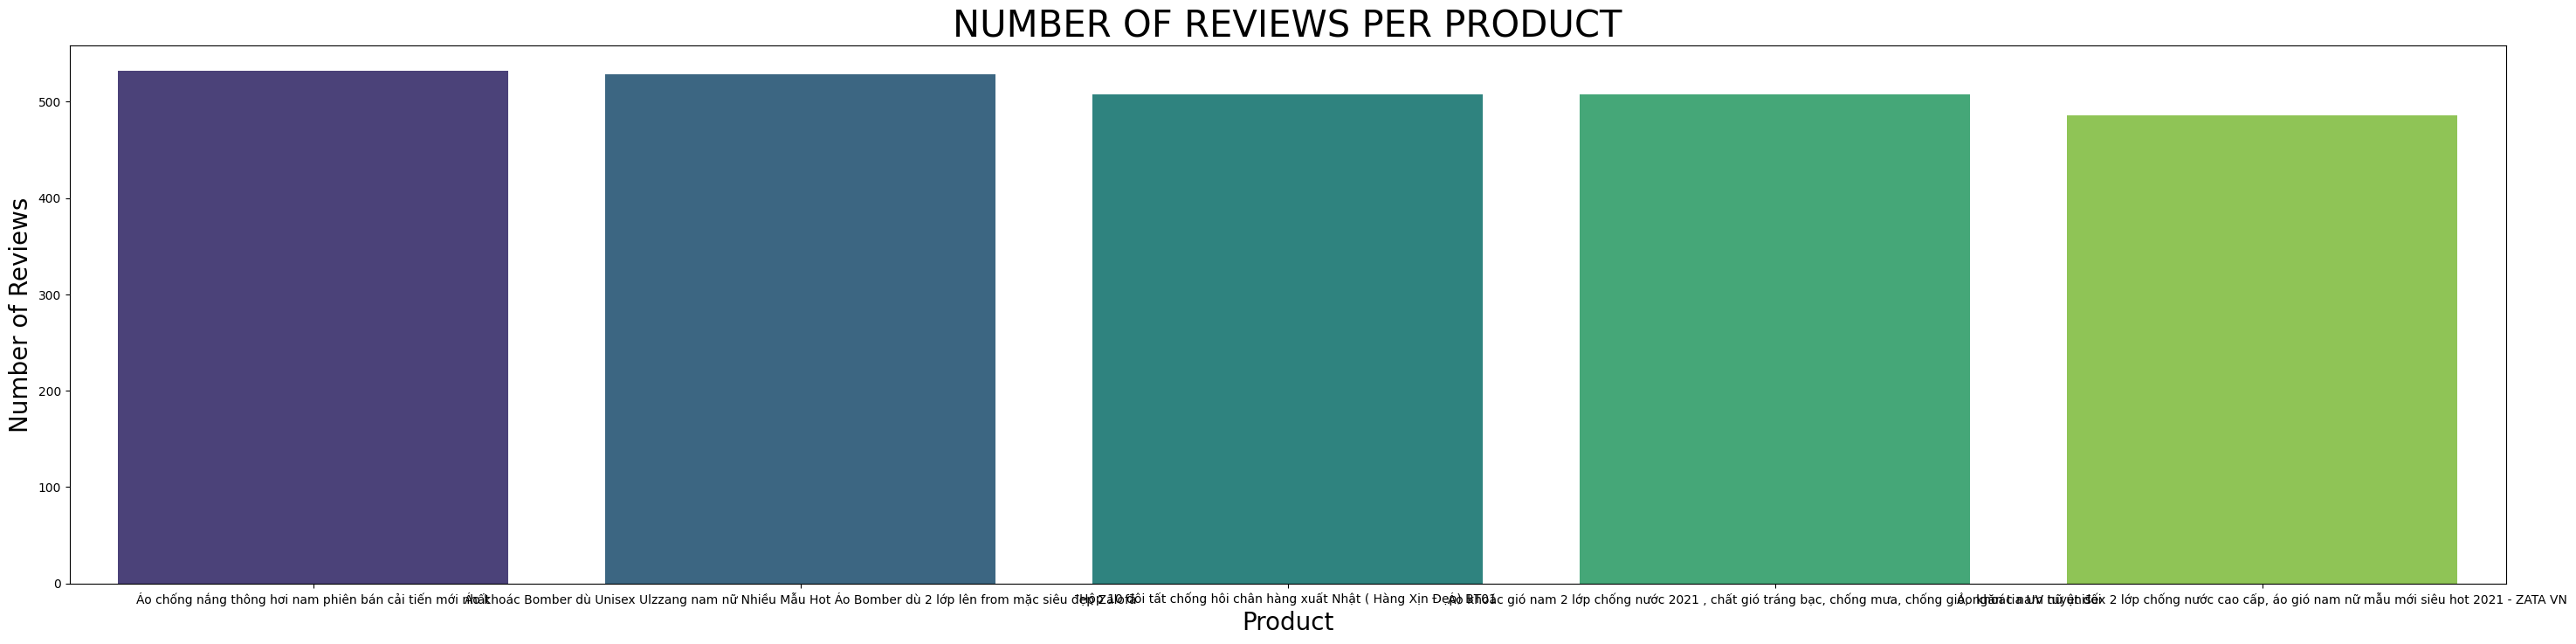

In [ ]:
# plt.figure(figsize=(36,8))
# sns.barplot(count_reviews.sort_values(by='count_no_reviews', ascending=False).head(5), y='count_no_reviews', x='product_name', palette='viridis', ci=None)
# plt.xlabel('Product', fontsize=20)
# plt.ylabel('Number of Reviews', fontsize=20)
# plt.title('NUMBER OF REVIEWS PER PRODUCT', fontsize=30)
# plt.show()

<ipython-input-32-663344705c9b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=top_5_reviews.index.astype(str),


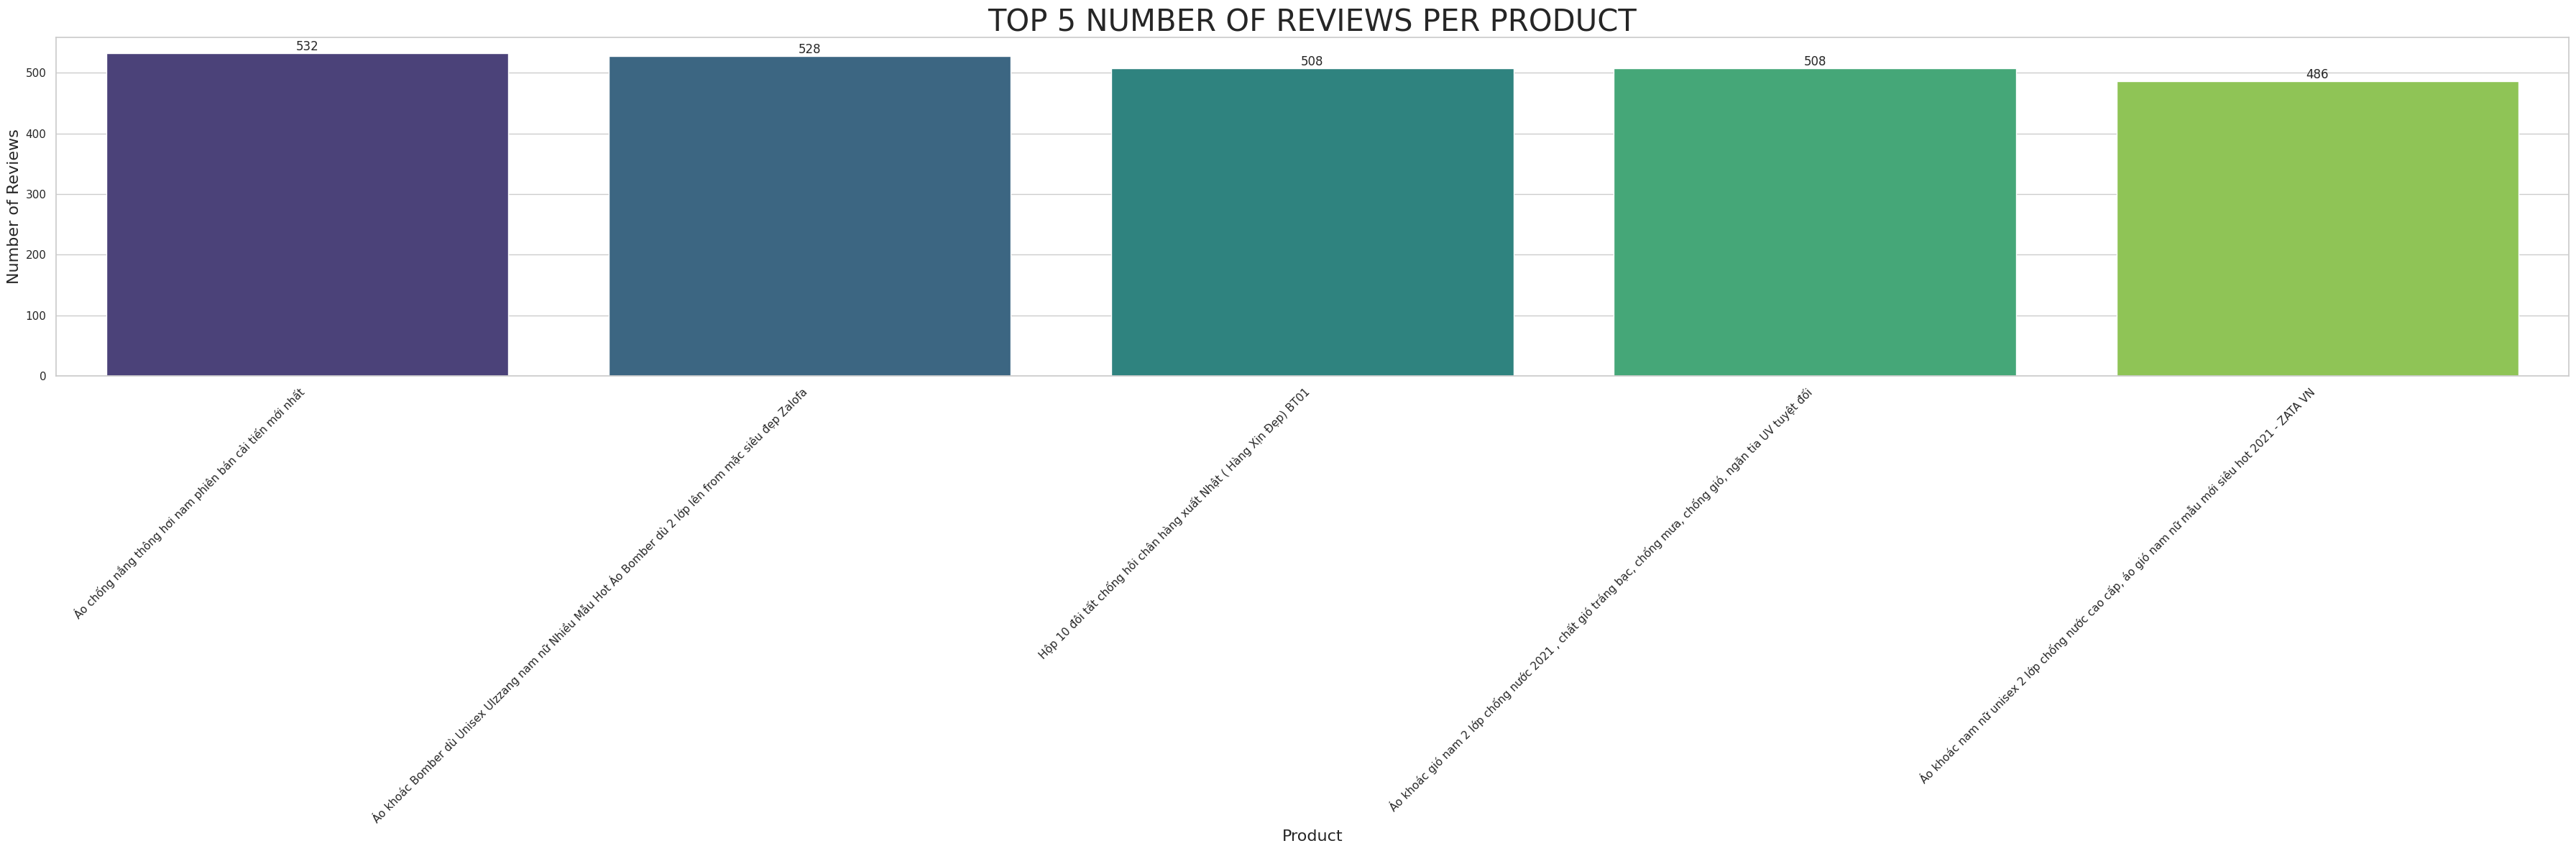

In [ ]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(36, 12))
barplot = sns.barplot(x=top_5_reviews.index.astype(str),
                      y=top_5_reviews['count_no_reviews'],
                      palette='viridis',
                      order=top_5_reviews.index.astype(str))
plt.xlabel('Product', fontsize=16)
plt.ylabel('Number of Reviews', fontsize=16)
plt.title('TOP 5 NUMBER OF REVIEWS PER PRODUCT', fontsize=30)
plt.xticks(rotation=45, ha='right')

for container in barplot.containers:
    barplot.bar_label(container, fmt='%.0f')

plt.tight_layout()
plt.show()

In [ ]:
# Tổng lượt mua hàng tính theo rating/review. Cứ mỗi một lượt rating sẽ được tính thành 1 lượt mua
total_purchases = df['rating'].count()
print(total_purchases)

994751


In [ ]:
# Users with the most purchases and their purchase amount
top_users = df[['user_id', 'rating', 'price']].groupby('user_id').agg(purchases=('rating', 'count'), purchase_amount=('price', 'sum')).sort_values(by='purchase_amount', ascending=False)
top_users[['purchases', 'purchase_amount']].head()

,purchases,purchase_amount
user_id,,
199,12951,1.622941e+09
831,2333,3.023502e+08
159,2375,2.969282e+08
324,2228,2.780948e+08
860,1950,2.462154e+08


In [ ]:
top_10_users_by_purchases = top_users.sort_values(by='purchases', ascending=False).head(10)

In [ ]:
# Format price
top_10_users_by_purchases['purchase amount'] = top_users['purchase_amount'].apply(format_currency)
top_10_users_by_purchases[['purchases', 'purchase amount']].head(10)

,purchases,purchase amount
user_id,,
199,12951,"1,622,941,264"
159,2375,"296,928,208"
831,2333,"302,350,177"
324,2228,"278,094,806"
164,1953,"243,017,554"
860,1950,"246,215,378"
1938,1759,"219,329,800"
241,1725,"215,445,624"
167,1718,"215,995,246"


- User 199 là người mua nhiều nhất với tổng số lần mua là 12,951 lần, tương ứng với 1,6 tỷ đồng

<ipython-input-37-8d65d6ef8a35>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=top_10_users_by_purchases.index.astype(str),


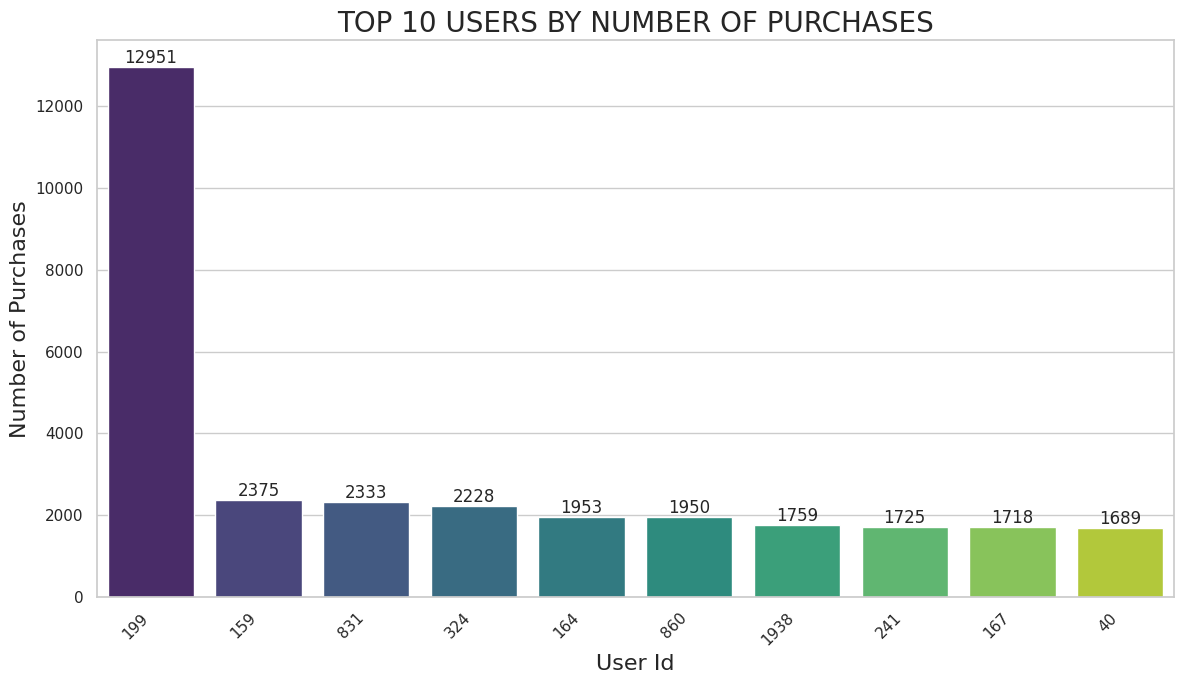

In [ ]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 7))
barplot = sns.barplot(x=top_10_users_by_purchases.index.astype(str),
                      y=top_10_users_by_purchases['purchases'],
                      palette='viridis',
                      order=top_10_users_by_purchases.index.astype(str))
plt.xlabel('User Id', fontsize=16)
plt.ylabel('Number of Purchases', fontsize=16)
plt.title('TOP 10 USERS BY NUMBER OF PURCHASES', fontsize=20)
plt.xticks(rotation=45, ha='right')

for container in barplot.containers:
    barplot.bar_label(container, fmt='%.0f')

plt.tight_layout()
plt.show()

In [ ]:
top_10_users_by_purchase_amount = top_users.sort_values(by='purchase_amount', ascending=False).head(10)

In [ ]:
# Format price
top_10_users_by_purchase_amount['purchase amount'] = top_users['purchase_amount'].apply(format_currency)
top_10_users_by_purchase_amount[['purchases', 'purchase amount']].head(10)

,purchases,purchase amount
user_id,,
199,12951,"1,622,941,264"
831,2333,"302,350,177"
159,2375,"296,928,208"
324,2228,"278,094,806"
860,1950,"246,215,378"
164,1953,"243,017,554"
40,1689,"219,887,098"
1938,1759,"219,329,800"
167,1718,"215,995,246"


<ipython-input-40-48bdecfc8aef>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=top_10_users_by_purchase_amount.index.astype(str),


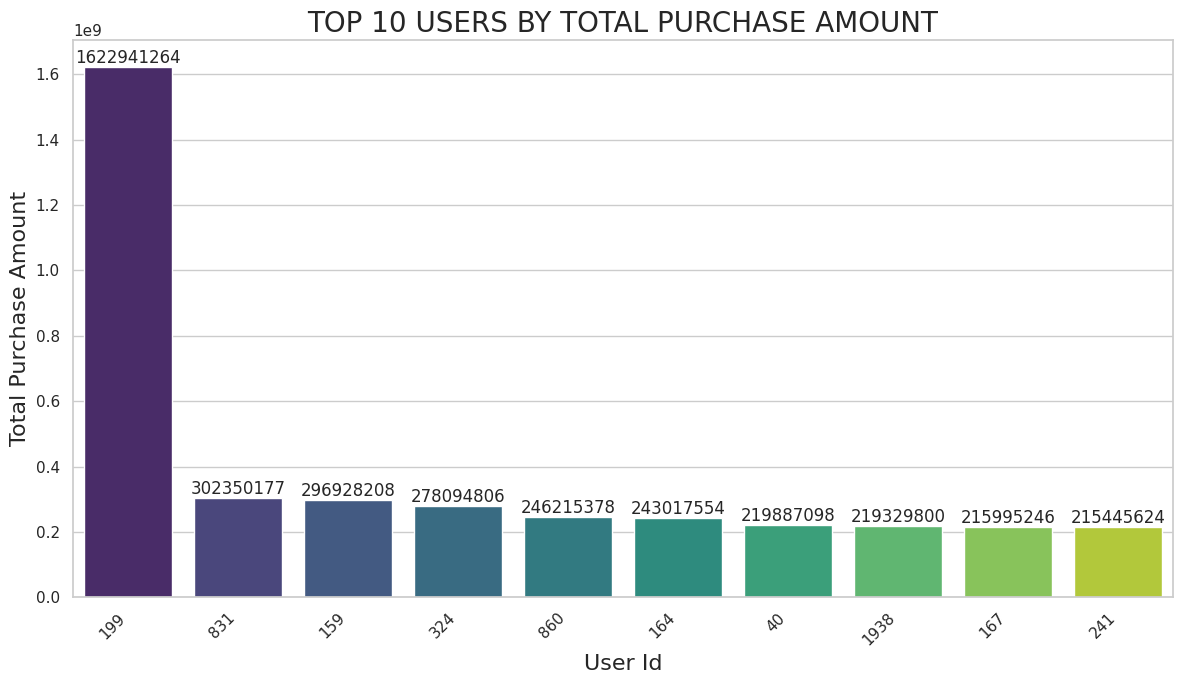

In [ ]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(12, 7))
barplot = sns.barplot(x=top_10_users_by_purchase_amount.index.astype(str),
                      y=top_10_users_by_purchase_amount['purchase_amount'],
                      palette='viridis',
                      order=top_10_users_by_purchase_amount.index.astype(str))
plt.xlabel('User Id', fontsize=16)
plt.ylabel('Total Purchase Amount', fontsize=16)
plt.title('TOP 10 USERS BY TOTAL PURCHASE AMOUNT', fontsize=20)
plt.xticks(rotation=45, ha='right')

for container in barplot.containers:
    barplot.bar_label(container, fmt='%.0f')

plt.tight_layout()
plt.show()

In [ ]:
# Top revenue contributors
top_contributors = df.groupby('sub_category').agg({'product_name': lambda x: x.mode().iloc[0], 'rating': 'count', 'price': 'sum'})
top_contributors = top_contributors.rename(columns={'product_name': 'most_reviewed_product', 'rating': 'purchases', 'price': 'total_revenue'}).sort_values(by='total_revenue', ascending=False)
top_contributors['percent_amount'] = top_contributors['total_revenue']/sum(top_contributors['total_revenue'])*100
top_contributors

,most_reviewed_product,purchases,total_revenue,percent_amount
sub_category,,,,
Đồ Bộ,"Set đồ nam Bộ Quần Áo Thể Thao Nam , nữ thời t...",196135,2.728036e+10,21.539333
Áo Khoác,Áo chống nắng thông hơi nam phiên bán cải tiến...,81928,1.769755e+10,13.973180
Áo,Áo sơ mi nam nữ dài tay Unisex Basic màu trắng...,107339,1.336183e+10,10.549892
Quần Jeans,Quần jean nam baggy kiểu ống rộng dáng suông c...,62617,1.278576e+10,10.095056
Quần Dài/Quần Âu,Quần Thể Thao Nam 3 Sọc Quần Nam Thu Đông Co G...,72755,1.077093e+10,8.504237
"Áo Hoodie, Áo Len & Áo Nỉ",Áo khoác nỉ hoodie trơn Unisex - Hoodie zip fo...,51309,8.979486e+09,7.089793
Vớ/Tất,Hộp 10 đôi tất chống hôi chân hàng xuất Nhật (...,160658,6.258613e+09,4.941516
Khác,Mũ Lưỡi Trai Phản Quang LINJW Dành Cho Nam Và ...,56998,5.997269e+09,4.735170
Đồ Lót,"Quần lót nam mềm mại co giãn, Sịp nam đùi Full...",70405,5.255857e+09,4.149786


In [ ]:
top_contributors['total revenue'] = top_contributors['total_revenue'].apply(format_currency)
top_contributors[['most_reviewed_product', 'purchases', 'total revenue', 'percent_amount']].head()

,most_reviewed_product,purchases,total revenue,percent_amount
sub_category,,,,
Đồ Bộ,"Set đồ nam Bộ Quần Áo Thể Thao Nam , nữ thời t...",196135,"27,280,362,712",21.539333
Áo Khoác,Áo chống nắng thông hơi nam phiên bán cải tiến...,81928,"17,697,549,394",13.973180
Áo,Áo sơ mi nam nữ dài tay Unisex Basic màu trắng...,107339,"13,361,829,098",10.549892
Quần Jeans,Quần jean nam baggy kiểu ống rộng dáng suông c...,62617,"12,785,761,923",10.095056
Quần Dài/Quần Âu,Quần Thể Thao Nam 3 Sọc Quần Nam Thu Đông Co G...,72755,"10,770,930,866",8.504237


<ipython-input-43-c1c4bce852a0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_contributors.sort_values(by='purchases', ascending=False), x='sub_category', y='purchases', ax=axes[0], palette='viridis')
<ipython-input-43-c1c4bce852a0>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_contributors, x='sub_category', y='total_revenue', ax=axes[1], palette='viridis')


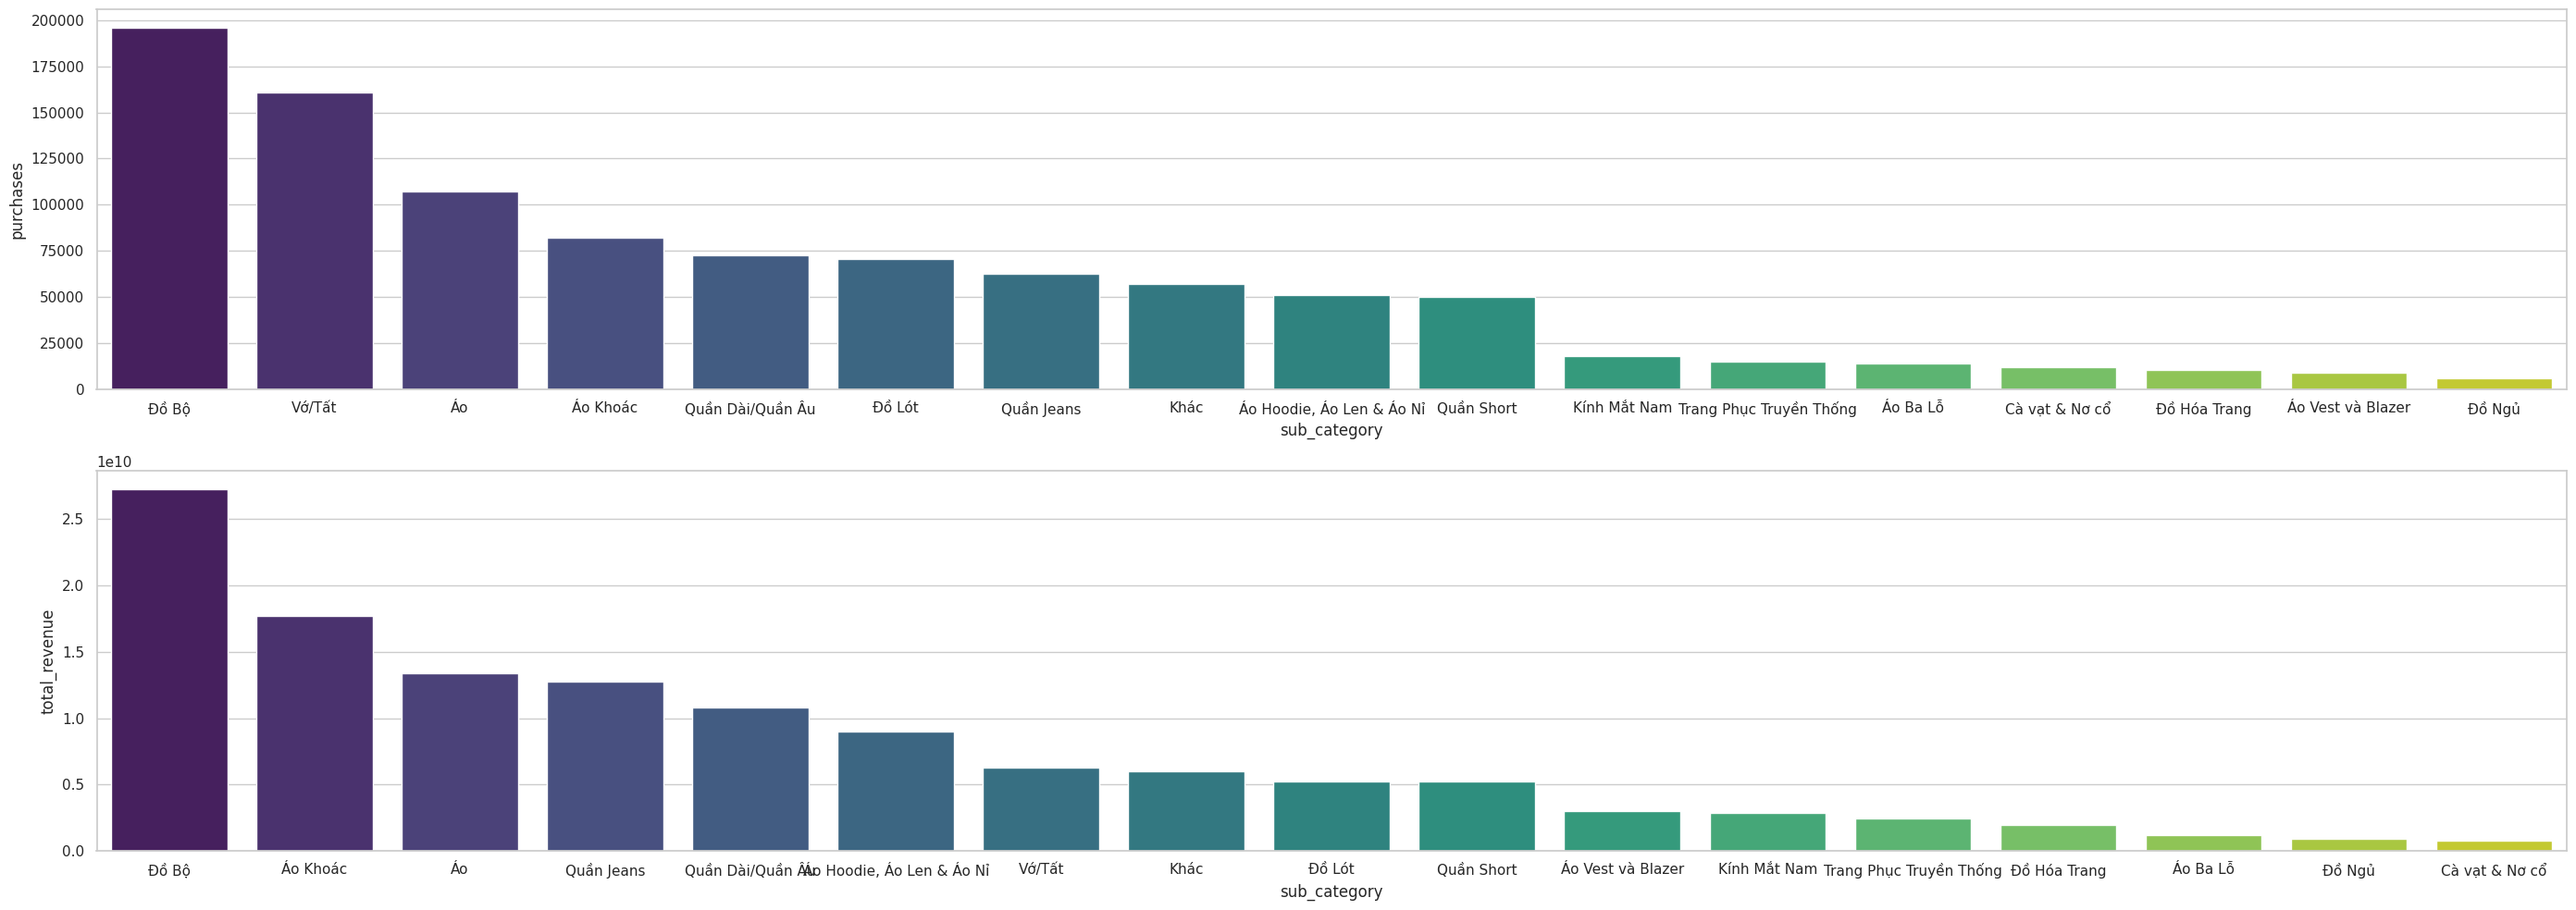

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(28, 10))
sns.barplot(data=top_contributors.sort_values(by='purchases', ascending=False), x='sub_category', y='purchases', ax=axes[0], palette='viridis')
sns.barplot(data=top_contributors, x='sub_category', y='total_revenue', ax=axes[1], palette='viridis')
plt.tight_layout()
plt.show()

- Mặt hàng 'Đồ Bộ' có tổng số lượt mua là 196,135 lần, chiếm doanh thu cao nhất khoảng 27,3 tỷ đồng

<ipython-input-44-6fba70034d77>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='rating', palette='viridis')


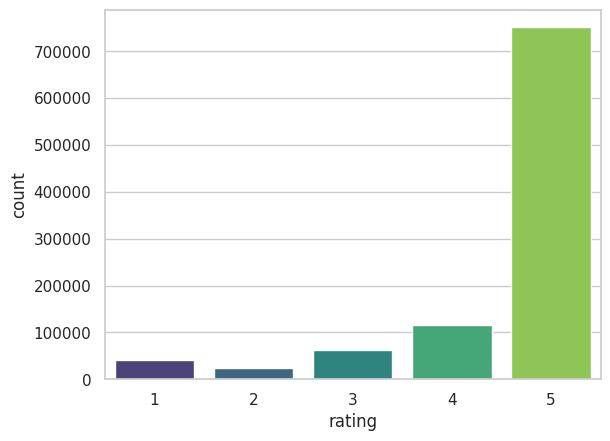

In [ ]:
# Thống kê rating
sns.countplot(data=df, x='rating', palette='viridis')
plt.show()

In [ ]:
# Top 5 sản phẩm được đánh giá 5 sao nhiều nhất
df[df['rating']==5]['product_name'].value_counts().head(5)

,count
product_name,
"Set đồ nam Bộ Quần Áo Thể Thao Nam , nữ thời trang",369
Sét Bộ quần áo nam - vải thấm mồ hôi tốt,318
Bộ thể thao nam,222
1 ĐÔI VỚ siêu ngắn giành cho nam giới - MÀU NGẪU NHIÊN,184
Quần áo khách đặt livestream,178


<ipython-input-46-79db065c2a3f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df[df['rating']==5]['product_name'].value_counts().head().reset_index(), y='count', x='product_name', palette='viridis')


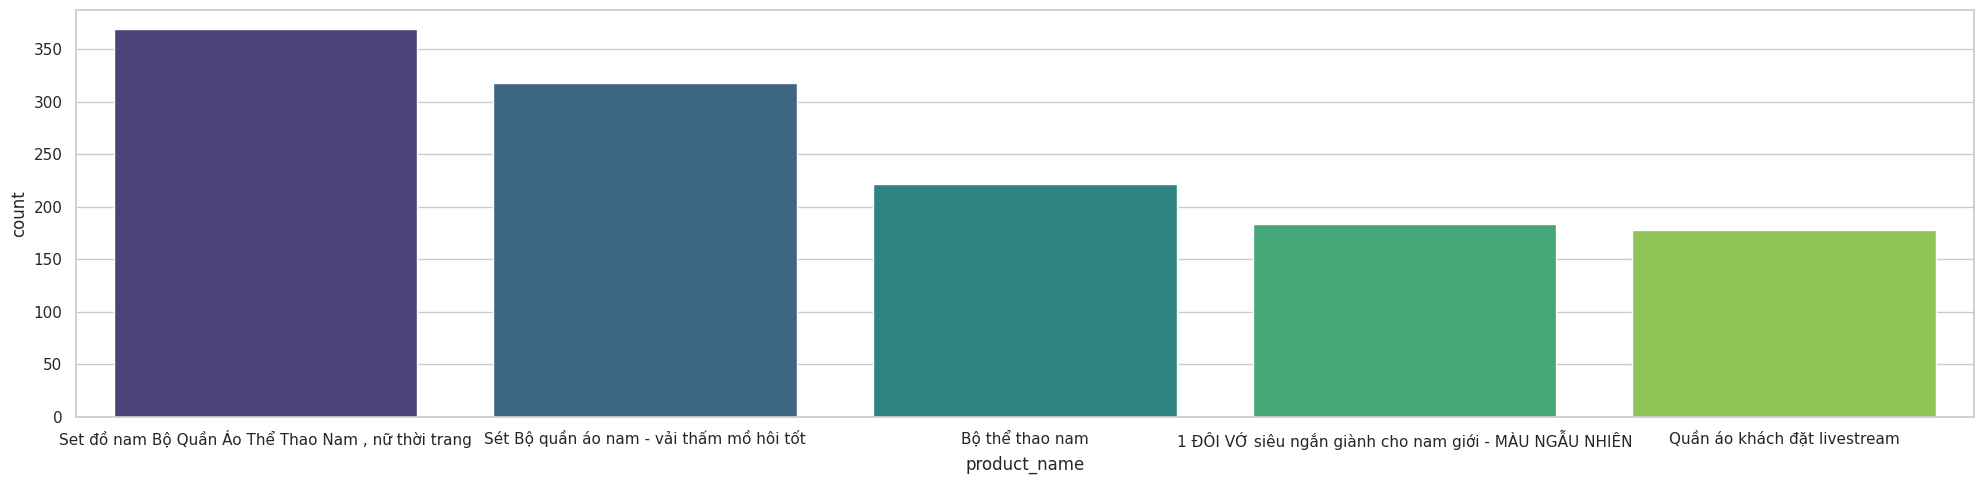

In [ ]:
plt.figure(figsize=(20, 5))
sns.barplot(data=df[df['rating']==5]['product_name'].value_counts().head().reset_index(), y='count', x='product_name', palette='viridis')
plt.tight_layout()

## Building the Content-Based Recommendation System

### Underthesea

In [ ]:
from underthesea import word_tokenize, pos_tag, sent_tokenize

In [ ]:
df_new = file_1_n.copy()
df_new.head()

,product_id,product_name,category,sub_category,link,price,rating,description
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,86250.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,26800.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,39500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,16500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,45000.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...


In [ ]:
# Hàm kiểm tra từ có phải là từ tiếng Việt "sạch"
def is_valid_vietnamese(word):
    vietnamese_chars = (
        "a-zA-Z0-9_"
        "àáạảãâầấậẩẫăằắặẳẵ"
        "èéẹẻẽêềếệểễ"
        "ìíịỉĩ"
        "òóọỏõôồốộổỗơờớợởỡ"
        "ùúụủũưừứựửữ"
        "ỳýỵỷỹ"
        "đ"
        "ÀÁẠẢÃÂẦẤẬẨẪĂẰẮẶẲẴ"
        "ÈÉẸẺẼÊỀẾỆỂỄ"
        "ÌÍỊỈĨ"
        "ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ"
        "ÙÚỤỦŨƯỪỨỰỬỮ"
        "ỲÝỴỶỸ"
        "Đ"
    )
    pattern = f'^[{vietnamese_chars}]+$'
    return re.match(pattern, word) is not None

In [ ]:
# Hàm xử lý một mô tả
def filter_vietnamese_words(text):
    if not isinstance(text, str):
        return ''
    words = text.split()
    clean_words = [w for w in words if is_valid_vietnamese(w)]
    return ' '.join(clean_words)

In [ ]:
# Áp dụng lọc cho cột 'product_name'
df_new['cleaned_product_name'] = df_new['product_name'].apply(filter_vietnamese_words)

In [ ]:
print(df_new[['product_name', 'cleaned_product_name']])

                                            product_name  \
0                  Áo ba lỗ thun gân ,form body tôn dáng   
1      Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp   
2      Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...   
3                     ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON   
4      Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...   
...                                                  ...   
49658  Tất vớ nam cổ cao cao cấp, tất vớ đi giày công...   
49659  Tất Nam Livan Sport Chất Liệu Bamboo Kháng Khu...   
49660  Combo 3 Đôi Tất ( Vớ ) Hài Chống Hôi Chân Uni ...   
49661                  Hộp 10 đôi tất chống hôi chân nam   
49662      Combo 5 đôi tất nam nữ cao cấp không hôi chân   

                                    cleaned_product_name  
0                        Áo ba lỗ thun gân body tôn dáng  
1           Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Siêu Đẹp  
2      Áo Ba Lỗ Nam Tyasuo chất vải co dãn không mềm mịn  
3                          ÁO BA LỖ HÀNG VI

In [ ]:
df_new['cleaned_product_name'] = df_new['cleaned_product_name'].apply(lambda x:x.lower())
df_new['cleaned_product_name'].head()

,cleaned_product_name
0,áo ba lỗ thun gân body tôn dáng
1,áo ba lỗ nam trắng chất cotton siêu siêu đẹp
2,áo ba lỗ nam tyasuo chất vải co dãn không mềm mịn
3,áo ba lỗ hàng việt nam cotton
4,áo thun nam thể thao ba lỗ mẫu mới siêu đẹp


In [ ]:
# Áp dụng lọc cho cột 'description'
df_new['cleaned_description'] = df_new['description'].apply(filter_vietnamese_words)

In [ ]:
print(df_new[['description', 'cleaned_description']])

                                             description  \
0      Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...   
1      Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...   
2      Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...   
3      Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...   
4      Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...   
...                                                  ...   
49658  Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nChiề...   
49659  Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nThươ...   
49660  Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nChất...   
49661  Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nKho ...   
49662  Danh Mục\nShopee\nThời Trang Nam\nVớ/Tất\nXuất...   

                                     cleaned_description  
0      Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Chiều ...  
1      Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Xuất x...  
2      Danh Mục Shopee Thời Trang Nam Áo Ba Lỗ Thương...  
3      Danh Mục Shopee Thời Trang Nam Áo Ba

In [ ]:
df_new['cleaned_description'] = [sentence[16:] for sentence in df_new['cleaned_description']]
df_new['cleaned_description'] = df_new['cleaned_description'].apply(lambda x:x.lower())
df_new['cleaned_description'].head()

,cleaned_description
0,thời trang nam áo ba lỗ chiều dài tay áo khác ...
1,thời trang nam áo ba lỗ xuất xứ việt nam tên t...
2,thời trang nam áo ba lỗ thương hiệu tyasuo chi...
3,thời trang nam áo ba lỗ chất liệu cotton kho h...
4,thời trang nam áo ba lỗ chiều dài tay áo không...


In [ ]:
# Tạo nội dung tổng hợp
df_new['content'] = df_new['cleaned_product_name'] + ' ' + df_new['cleaned_description'].apply(lambda x: ' '.join(x.split()[:100]))
df_new['content'].head()

,content
0,áo ba lỗ thun gân body tôn dáng thời trang nam...
1,áo ba lỗ nam trắng chất cotton siêu siêu đẹp t...
2,áo ba lỗ nam tyasuo chất vải co dãn không mềm ...
3,áo ba lỗ hàng việt nam cotton thời trang nam á...
4,áo thun nam thể thao ba lỗ mẫu mới siêu đẹp th...


In [ ]:
# Chuẩn hóa content chỉ lấy word có nghĩa
df_new['fm_content'] = df_new['content'].apply(lambda x: ' '.join([word for word in x.split() if not word in STOP_WORD_FILE]))

In [ ]:
df_new['fm_content'].head()

,fm_content
0,áo ba lỗ thun gân body tôn dáng thời trang áo ...
1,áo ba lỗ trắng chất cotton siêu siêu đẹp thời ...
2,áo ba lỗ tyasuo chất vải dãn không mềm mịn thờ...
3,áo ba lỗ hàng việt cotton thời trang áo ba lỗ ...
4,áo thun thể thao ba lỗ mẫu mới siêu đẹp thời t...


In [ ]:
# Underthesea word segmentation
start_time = time.time()

df_new['cleaned_fm_content'] = df_new['fm_content'].apply(lambda x: word_tokenize(x, format='text'))

tokenize_time = time.time() - start_time
print(f'Thời gian thực thi: {tokenize_time:.2f} giây')

Thời gian thực thi: 420.69 giây


In [ ]:
df_new['cleaned_fm_content'].head(5)

,cleaned_fm_content
0,áo ba lỗ thun gân body tôn_dáng thời_trang áo ...
1,áo ba lỗ trắng chất cotton siêu_siêu đẹp thời_...
2,áo ba lỗ tyasuo chất vải_dãn không mềm mịn thờ...
3,áo ba lỗ hàng việt cotton thời_trang áo ba lỗ ...
4,áo thun thể_thao ba lỗ mẫu mới siêu_đẹp thời_t...


### Gensim

In [ ]:
from gensim import corpora, models, similarities

In [ ]:
# Tokenize (split) the sentences into words
token_fm_content = [[text for text in x.split()] for x in df_new.cleaned_fm_content]
print(token_fm_content)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
len(token_fm_content)

49663

In [ ]:
token_fm_content[:1]

[['áo',
  'ba',
  'lỗ',
  'thun',
  'gân',
  'body',
  'tôn_dáng',
  'thời_trang',
  'áo',
  'ba',
  'lỗ',
  'chiều',
  'dài',
  'tay_áo',
  'khác',
  'phong_cách',
  'thể',
  'cơ_đường',
  'nhiệt_đới',
  'tall',
  'fit',
  'có',
  'xuất_xứ',
  'việt_dáng',
  'kiểu',
  'áo',
  'ôm',
  'sát',
  'chất_liệu',
  'cotton_mẫu',
  'sọc_tăm',
  'có',
  'gân',
  'nổi',
  'kho',
  'hàng',
  '75317',
  'gửi',
  'từ',
  'bà',
  'rịa',
  'vũng',
  'tàu',
  'best',
  'tank',
  'tops',
  'for',
  'men',
  '2021',
  'áo',
  'ba',
  'lỗ',
  'quốc_dân',
  'cho',
  'bảng',
  'size',
  'size',
  'size',
  'l',
  '55',
  'kg',
  'size',
  'xl',
  '70',
  'kg',
  'size',
  'xxl',
  '75',
  'kg',
  '80',
  'kg',
  'size',
  'này',
  'là',
  'chuẩn',
  'mặc',
  'kiểu',
  'body_nha',
  'quý_khách',
  'còn',
  'nếu',
  'khách',
  'nào',
  'không',
  'thích',
  'mặc',
  'ôm',
  'thì',
  'tăng',
  'lên',
  '1',
  'size',
  'nhé',
  'còn']]

In [ ]:
# Tiền xử lý dữ liệu
token_fm_content_re = [[re.sub('[0-9]+','', e) for e in text] for text in token_fm_content] # xem xét có cần bỏ các con số hay không
token_fm_content_re = [[t.lower() for t in text if not t in ['', ' ', ',', '.', '...', '-',':', ';', '?', '%', '(', ')', '+', '/', '\\', "'", '&', '[', ']']] for text in token_fm_content] # kiểm tra nội dung và đưa vào các ký tự đặc biệt
token_fm_content_re = [[t for t in text if not t in STOP_WORD_FILE] for text in token_fm_content] # stopword

In [ ]:
token_fm_content_re[:1]

[['áo',
  'ba',
  'lỗ',
  'thun',
  'gân',
  'body',
  'tôn_dáng',
  'thời_trang',
  'áo',
  'ba',
  'lỗ',
  'chiều',
  'dài',
  'tay_áo',
  'khác',
  'phong_cách',
  'thể',
  'cơ_đường',
  'nhiệt_đới',
  'tall',
  'fit',
  'có',
  'xuất_xứ',
  'việt_dáng',
  'kiểu',
  'áo',
  'ôm',
  'sát',
  'chất_liệu',
  'cotton_mẫu',
  'sọc_tăm',
  'có',
  'gân',
  'nổi',
  'kho',
  'hàng',
  '75317',
  'gửi',
  'từ',
  'bà',
  'rịa',
  'vũng',
  'tàu',
  'best',
  'tank',
  'tops',
  'for',
  'men',
  '2021',
  'áo',
  'ba',
  'lỗ',
  'quốc_dân',
  'cho',
  'bảng',
  'size',
  'size',
  'size',
  'l',
  '55',
  'kg',
  'size',
  'xl',
  '70',
  'kg',
  'size',
  'xxl',
  '75',
  'kg',
  '80',
  'kg',
  'size',
  'này',
  'là',
  'chuẩn',
  'mặc',
  'kiểu',
  'body_nha',
  'quý_khách',
  'còn',
  'nếu',
  'khách',
  'nào',
  'không',
  'thích',
  'mặc',
  'ôm',
  'thì',
  'tăng',
  'lên',
  '1',
  'size',
  'nhé',
  'còn']]

In [ ]:
# Obtain the number of features based on dictionary: Use corpora.Dictionary
dictionary = corpora.Dictionary(token_fm_content_re)

In [ ]:
# List of features in dictionary
dictionary.token2id

{'1': 0,
 '2021': 1,
 '55': 2,
 '70': 3,
 '75': 4,
 '75317': 5,
 '80': 6,
 'ba': 7,
 'best': 8,
 'body': 9,
 'body_nha': 10,
 'bà': 11,
 'bảng': 12,
 'chiều': 13,
 'cho': 14,
 'chuẩn': 15,
 'chất_liệu': 16,
 'cotton_mẫu': 17,
 'còn': 18,
 'có': 19,
 'cơ_đường': 20,
 'dài': 21,
 'fit': 22,
 'for': 23,
 'gân': 24,
 'gửi': 25,
 'hàng': 26,
 'kg': 27,
 'kho': 28,
 'khác': 29,
 'khách': 30,
 'không': 31,
 'kiểu': 32,
 'l': 33,
 'là': 34,
 'lên': 35,
 'lỗ': 36,
 'men': 37,
 'mặc': 38,
 'nhiệt_đới': 39,
 'nhé': 40,
 'nào': 41,
 'này': 42,
 'nếu': 43,
 'nổi': 44,
 'phong_cách': 45,
 'quý_khách': 46,
 'quốc_dân': 47,
 'rịa': 48,
 'size': 49,
 'sát': 50,
 'sọc_tăm': 51,
 'tall': 52,
 'tank': 53,
 'tay_áo': 54,
 'thun': 55,
 'thì': 56,
 'thích': 57,
 'thể': 58,
 'thời_trang': 59,
 'tops': 60,
 'tàu': 61,
 'tôn_dáng': 62,
 'tăng': 63,
 'từ': 64,
 'việt_dáng': 65,
 'vũng': 66,
 'xl': 67,
 'xuất_xứ': 68,
 'xxl': 69,
 'áo': 70,
 'ôm': 71,
 '100': 72,
 '61911': 73,
 'azman': 74,
 'bạn': 75,
 'chất': 7

In [ ]:
# Numbers of features (word) in dictionary
feature_cnt = len(dictionary.token2id)

In [ ]:
feature_cnt

88921

In [ ]:
# Obtain corpus based on dictionary (dense matrix)
corpus_gensim = [dictionary.doc2bow(text) for text in token_fm_content_re]

In [ ]:
# Hiển thị id và số lần xuất hiện của token trong câu
corpus_gensim[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 3),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 2),
 (19, 2),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 2),
 (25, 1),
 (26, 1),
 (27, 4),
 (28, 1),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 2),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 3),
 (37, 1),
 (38, 2),
 (39, 1),
 (40, 1),
 (41, 1),
 (42, 1),
 (43, 1),
 (44, 1),
 (45, 1),
 (46, 1),
 (47, 1),
 (48, 1),
 (49, 7),
 (50, 1),
 (51, 1),
 (52, 1),
 (53, 1),
 (54, 1),
 (55, 1),
 (56, 1),
 (57, 1),
 (58, 1),
 (59, 1),
 (60, 1),
 (61, 1),
 (62, 1),
 (63, 1),
 (64, 1),
 (65, 1),
 (66, 1),
 (67, 1),
 (68, 1),
 (69, 1),
 (70, 4),
 (71, 2)]

In [ ]:
# Use TF-IDF Model to process corpus, obtaining index
tfidf_gensim = models.TfidfModel(corpus_gensim)
# Apply TF-IDF transformation
corpus_tfidf = tfidf_gensim[corpus_gensim]
# Tính toán sự tương tự trong ma trận thưa thớt
index_gensim = similarities.SparseMatrixSimilarity(tfidf_gensim[corpus_gensim],
                                            num_features=feature_cnt)

In [ ]:
# Example: Get similarities for the first sentence against all others
sen_index = 0
query_vector_tfidf = corpus_tfidf[sen_index]
sims_for_one_sen = index_gensim[query_vector_tfidf]

In [ ]:
print(f'Similarities for Sentence {sen_index}:')
for sen_id, score in enumerate(sims_for_one_sen):
    print(f'Sentence {sen_id}: {score:.4f}')

Similarities for Sentence 0:
Sentence 0: 1.0000
Sentence 1: 0.1030
Sentence 2: 0.1212
Sentence 3: 0.1991
Sentence 4: 0.2271
Sentence 5: 0.1065
Sentence 6: 0.1992
Sentence 7: 0.2278
Sentence 8: 0.0955
Sentence 9: 0.1073
Sentence 10: 0.1576
Sentence 11: 0.0752
Sentence 12: 0.1125
Sentence 13: 0.1034
Sentence 14: 0.2453
Sentence 15: 0.1241
Sentence 16: 0.1473
Sentence 17: 0.1250
Sentence 18: 0.1967
Sentence 19: 0.1024
Sentence 20: 0.2081
Sentence 21: 0.0586
Sentence 22: 0.1668
Sentence 23: 0.2323
Sentence 24: 0.1603
Sentence 25: 0.1614
Sentence 26: 0.1196
Sentence 27: 0.1201
Sentence 28: 0.1402
Sentence 29: 0.2198
Sentence 30: 0.1168
Sentence 31: 0.2400
Sentence 32: 0.1303
Sentence 33: 0.1551
Sentence 34: 0.1871
Sentence 35: 0.1196
Sentence 36: 0.1876
Sentence 37: 0.1213
Sentence 38: 0.0985
Sentence 39: 0.2053
Sentence 40: 0.0970
Sentence 41: 0.1873
Sentence 42: 0.1369
Sentence 43: 0.1062
Sentence 44: 0.1717
Sentence 45: 0.1604
Sentence 46: 0.1140
Sentence 47: 0.1477
Sentence 48: 0.1546
S

In [ ]:
def find_similar_documents_by_content(view_content, top_n=3):
    # Pre-processing content
    view_content = view_content.lower()
    view_content = re.sub(r'[^\w\s]', '', view_content)
    view_content = re.sub(r'\s+', ' ', view_content)
    view_content = ' '.join([word for word in view_content.split() if word not in STOP_WORD_FILE])

    # Convert search words into Sparse Vectors
    kw_vector = dictionary.doc2bow(view_content.split())

    # Calculate similarities
    sim_gem = index_gensim[tfidf_gensim[kw_vector]]

    # 3. Print similar documents
    print_similar_documents(sim_gem, top_n=top_n)

def print_similar_documents(sim_gem, top_n=5, exclude_self=True):
    # Sort the similarity scores in descending order
    sorted_sim_gem = sorted(enumerate(sim_gem), key=lambda x: x[1], reverse=True)

    # Get the starting index based on whether to exclude self
    start_index = 1 if exclude_self else 0

    # Print the top_n similar documents
    for i, score in sorted_sim_gem[start_index:start_index + top_n]:
        print('keyword is similar to doc_index %d: %.4f' % (i, score))

In [ ]:
# Gọi function
view_content = 'áo ba lỗ nam'
find_similar_documents_by_content(view_content, top_n=3)

keyword is similar to doc_index 646: 0.8804
keyword is similar to doc_index 561: 0.8765
keyword is similar to doc_index 509: 0.8698


In [ ]:
'''
def recommend_products(content, top_n=3):
    # Pre-processing content
    content = content.lower()
    content = re.sub('[0-9]+', '', content)
    content = re.sub(r'[^\w\s]', '', content)
    content_tokens = [word for word in content.split() if word not in STOP_WORD_FILE]

    # Convert description into TF-IDF vector
    content_bow = dictionary.doc2bow(content_tokens)
    content_tfidf = tfidf[content_bow]

    # Calculate similarity with all items in corpus
    similarities = index[content_tfidf]

    # Get index of top_n similar products
    similar_indices = similarities.argsort()[-top_n:][::-1]

    # Returns the names of top_n similar products
    recommended_products = df_new['product_name'].iloc[similar_indices]
    return recommended_products
'''

In [ ]:
# Hàm đề xuất sản phẩm dựa trên nội dung user nhập vào
def recommend_similar_products_gensim_by_content(content, top_n=5):
    try:
        # Pre-processing content
        content = content.lower()
        content = re.sub(r'[^a-zàáạảãăắằẳẵặâấầẩẫậđèéẹẻẽêếềểễệìíịỉĩòóọỏõôốồổỗộơớờởỡợùúụủũưứừửữựỳýỵỷỹ\s]', '', content)
        content = ' '.join([word for word in content.split() if word not in STOP_WORD_FILE])

        # Convert description into TF-IDF vector
        content_bow = dictionary.doc2bow(content.split())
        content_tfidf = tfidf_gensim[content_bow]

        # Calculate similarity with all items in corpus
        sims = index_gensim[content_tfidf]

        # Get index of top_n similar products
        similar_indices = sims.argsort()[-top_n:][::-1]

        # Returns the names of top_n similar products
        recommended_products = df_new[['product_id', 'product_name', 'link', 'price', 'rating', 'sub_category', 'fm_content', 'cleaned_fm_content']].iloc[similar_indices]
        return recommended_products

    except IndexError:
        print('No matching products found for the given fm_content!!')
        return pd.DataFrame()

In [ ]:
# Gọi function
content = 'áo ba lỗ nam'
similar_product_names = recommend_similar_products_gensim_by_content(content, top_n=3)
print(f"Sản phẩm được đề xuất cho nội dung '{content}':")
similar_product_names

Sản phẩm được đề xuất cho nội dung 'áo ba lỗ nam':


,product_id,product_name,link,price,rating,sub_category,fm_content,cleaned_fm_content
940,19440,Áo ba lỗ nam,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-nam-i....,99000.0,5.0,Áo Ba Lỗ,áo ba lỗ,áo ba lỗ
646,191446,"[Áo 3 lỗ cotton thời trang] Áo ba lỗ nam nữ, Á...",https://shopee.vn/-%C3%81o-3-l%E1%BB%97-cotton...,105000.0,0.0,Áo Ba Lỗ,3 lỗ cotton thời áo ba lỗ áo ba lỗ cho ba lỗ i...,3 lỗ cotton thời áo ba lỗ áo ba lỗ cho ba lỗ i...
561,191361,(Giá Sỉ) [Áo 3 lỗ cotton thời trang] Áo ba lỗ ...,https://shopee.vn/(Gi%C3%A1-S%E1%BB%89)-%C3%81...,71829.0,0.0,Áo Ba Lỗ,3 lỗ cotton thời áo ba lỗ mùa áo ba lỗ thể tha...,3 lỗ cotton thời áo ba lỗ mùa áo ba lỗ thể_tha...


In [ ]:
# Gọi function
content = 'bộ đồ ngủ'
similar_product_names = recommend_similar_products_gensim_by_content(content, top_n=3)
print(f"Sản phẩm được đề xuất cho nội dung '{content}':")
similar_product_names

Sản phẩm được đề xuất cho nội dung 'bộ đồ ngủ':


,product_id,product_name,link,price,rating,sub_category,fm_content,cleaned_fm_content
24752,261056,Đồ Ngủ LUXURY LOLITA2000 [ FREESHIP ] ĐỒ NGỦ C...,https://shopee.vn/%C4%90%E1%BB%93-Ng%E1%BB%A7-...,345000.0,0.0,Đồ Ngủ,đồ ngủ luxury lolita2000 freeship đồ ngủ coupl...,đồ ngủ luxury lolita2000 freeship đồ ngủ coupl...
24510,26814,Bộ ngủ trung niên,https://shopee.vn/B%E1%BB%99-ng%E1%BB%A7-trung...,300000.0,0.0,Đồ Ngủ,bộ ngủ trung niên,bộ ngủ trung_niên
15815,233481,❤️Bộ Đồ Nữ ❤️ Bộ Đồ Nữ Mặc Nhà Nữ cộc tay hoạt...,https://shopee.vn/%E2%9D%A4%EF%B8%8FB%E1%BB%99...,66000.0,5.0,Đồ Bộ,đồ nữ bộ đồ nữ mặc nhà nữ cộc tay hoạt hình họ...,đồ nữ bộ_đồ nữ mặc nhà nữ cộc tay_hoạt_hình họ...


In [ ]:
# Hàm đề xuất sản phẩm dựa trên user nhập vào product_id
def recommend_similar_products_gensim_by_id(product_id, top_n=5):
    # Check if product_id exists in df_new
    if product_id not in df_new['product_id'].values:
        print(f'Product Id {product_id} not found in the dataset!')
        return pd.Series(dtype=object)

    # Get the index of the product
    idx = df_new.index[df_new['product_id'] == product_id][0]

    # Get the cleaned content of the selected product
    product_content = df_new['cleaned_fm_content'].iloc[idx]

    # Convert product content into Gensim vector
    content_bow = dictionary.doc2bow(product_content.split())
    content_tfidf = tfidf_gensim[content_bow]

    # Calculate similarity score using Gensim similarity
    sims = index_gensim[content_tfidf]

    # Get similarity scores and sort them
    sim_scores = list(enumerate(sims))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Exclude the product itself and select top_n similar products
    sim_scores = sim_scores[1:top_n + 1]

    # Get recommended product indices and names
    product_indices = [i[0] for i in sim_scores]
    recommended_products = df_new[['product_id', 'product_name', 'link', 'price', 'rating', 'sub_category', 'fm_content', 'cleaned_fm_content']].iloc[product_indices]

    return recommended_products

In [ ]:
# Gọi function
rec = recommend_similar_products_gensim_by_id(1964, top_n=3) # product_id = 1964 là áo thun ba lỗ
rec

,product_id,product_name,link,price,rating,sub_category,fm_content,cleaned_fm_content
99,1999,[MS038] Áo Thun Sát Nách Thời Trang Mùa Hè Cho...,https://shopee.vn/-MS038-%C3%81o-Thun-S%C3%A1t...,75000.0,4.9,Áo Ba Lỗ,áo thun sát nách thời trang mùa hè cho thời tr...,áo thun sát nách thời_trang mùa hè cho thời_tr...
201,191001,áo ba lỗ tập gym cao cấp hàng gym shark,https://shopee.vn/%C3%A1o-ba-l%E1%BB%97-t%E1%B...,210000.0,0.0,Áo Ba Lỗ,áo ba lỗ tập gym cao cấp hàng gym shark thời t...,áo ba lỗ tập gym cao_cấp hàng gym shark thời_t...
720,19220,"Áo thun ba lỗ nam adidas, áo ba lỗ nam sát nác...",https://shopee.vn/%C3%81o-thun-ba-l%E1%BB%97-n...,98000.0,5.0,Áo Ba Lỗ,áo thun ba lỗ áo ba lỗ sát nách thể thao tập g...,áo thun ba lỗ áo ba lỗ sát nách thể_thao tập g...


In [ ]:
# Hàm đề xuất sản phẩm dựa trên user nhập vào product_name hoặc product_id
import difflib

def recommend_similar_products_by_options(product_identifier, top_n=5, by_name=False):
    if by_name:
        # Find products with similar names using difflib
        list_of_all_products = df_new['product_name'].tolist()
        find_close_match = difflib.get_close_matches(product_identifier, list_of_all_products)

        if not find_close_match:
            print(f'No product found with name similar to: {product_identifier}')
            return pd.Series(dtype=object)

        close_match = find_close_match[0]  # Get the closest match
        idx = df_new.index[df_new.product_name == close_match].tolist()[0]
        # Get the cleaned content of the matched product
        product_content = df_new['cleaned_fm_content'].iloc[idx]
    else:
        # Find product index by ID
        if product_identifier not in df_new['product_id'].values:
            print(f'Product Id {product_identifier} not found in the dataset!')
            return pd.Series(dtype=object)

        idx = df_new.index[df_new['product_id'] == product_identifier][0]
        # Get the cleaned content of the selected product
        product_content = df_new['cleaned_fm_content'].iloc[idx]

    # Convert product content into Gensim vector
    content_bow = dictionary.doc2bow(product_content.split())
    content_tfidf = tfidf_gensim[content_bow]

    # Calculate similarity score using Gensim similarity
    sims = index_gensim[content_tfidf]

    # Get similarity scores and sort them
    sim_scores = list(enumerate(sims))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n + 1]  # Exclude the product itself

    # Get recommended product indices and names
    product_indices = [i[0] for i in sim_scores]
    recommended_products = df_new[['product_id', 'product_name', 'link', 'price', 'rating', 'sub_category', 'fm_content', 'cleaned_fm_content']].iloc[product_indices]
    return recommended_products

In [ ]:
# Gọi function (product_name)
product_identifier = 'áo ba lỗ nam'
rec = recommend_similar_products_by_options(product_identifier, top_n=3, by_name=True)
print(f"Sản phẩm được đề xuất cho nội dung '{product_identifier}':")
rec

Sản phẩm được đề xuất cho nội dung 'áo ba lỗ nam':


,product_id,product_name,link,price,rating,sub_category,fm_content,cleaned_fm_content
940,19440,Áo ba lỗ nam,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-nam-i....,99000.0,5.0,Áo Ba Lỗ,áo ba lỗ,áo ba lỗ
561,191361,(Giá Sỉ) [Áo 3 lỗ cotton thời trang] Áo ba lỗ ...,https://shopee.vn/(Gi%C3%A1-S%E1%BB%89)-%C3%81...,71829.0,0.0,Áo Ba Lỗ,3 lỗ cotton thời áo ba lỗ mùa áo ba lỗ thể tha...,3 lỗ cotton thời áo ba lỗ mùa áo ba lỗ thể_tha...
646,191446,"[Áo 3 lỗ cotton thời trang] Áo ba lỗ nam nữ, Á...",https://shopee.vn/-%C3%81o-3-l%E1%BB%97-cotton...,105000.0,0.0,Áo Ba Lỗ,3 lỗ cotton thời áo ba lỗ áo ba lỗ cho ba lỗ i...,3 lỗ cotton thời áo ba lỗ áo ba lỗ cho ba lỗ i...


In [ ]:
# Gọi function (product_id)
rec = recommend_similar_products_by_options(1964, top_n=3, by_name=False)
rec

,product_id,product_name,link,price,rating,sub_category,fm_content,cleaned_fm_content
99,1999,[MS038] Áo Thun Sát Nách Thời Trang Mùa Hè Cho...,https://shopee.vn/-MS038-%C3%81o-Thun-S%C3%A1t...,75000.0,4.9,Áo Ba Lỗ,áo thun sát nách thời trang mùa hè cho thời tr...,áo thun sát nách thời_trang mùa hè cho thời_tr...
201,191001,áo ba lỗ tập gym cao cấp hàng gym shark,https://shopee.vn/%C3%A1o-ba-l%E1%BB%97-t%E1%B...,210000.0,0.0,Áo Ba Lỗ,áo ba lỗ tập gym cao cấp hàng gym shark thời t...,áo ba lỗ tập gym cao_cấp hàng gym shark thời_t...
720,19220,"Áo thun ba lỗ nam adidas, áo ba lỗ nam sát nác...",https://shopee.vn/%C3%81o-thun-ba-l%E1%BB%97-n...,98000.0,5.0,Áo Ba Lỗ,áo thun ba lỗ áo ba lỗ sát nách thể thao tập g...,áo thun ba lỗ áo ba lỗ sát nách thể_thao tập g...


In [ ]:
import pickle

# Save the Gensim dictionary
with open('gensim_dictionary.pkl', 'wb') as f:
    pickle.dump(dictionary, f)

# Save the Gensim TF-IDF model
with open('gensim_tfidf_model.pkl', 'wb') as f:
    pickle.dump(tfidf_gensim, f)

# Save the Gensim similarity index
with open('gensim_similarity_index.pkl', 'wb') as f:
    pickle.dump(index_gensim, f)

In [ ]:
from google.colab import files

files.download('gensim_dictionary.pkl')
files.download('gensim_tfidf_model.pkl')
files.download('gensim_similarity_index.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Building model using Baseline Only from SurPrise

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505212 sha256=2e4be5089daeb53bc9c732355055b47575a3f3149284948f8242fb9b29145cd0
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


In [ ]:
from surprise import *
from surprise.model_selection.validation import cross_validate
from surprise.model_selection import GridSearchCV, train_test_split

In [ ]:
df_blo = file_2.copy()
df_blo.head(5)

,product_id,user_id,user,rating
0,190,1,karmakyun2nd,5
1,190,2,tranquangvinh_vv,5
2,190,3,nguyenquoctoan2005,5
3,190,4,nguyenthuyhavi,5
4,190,5,luonganh5595,5


In [ ]:
reader = Reader()
blo = Dataset.load_from_df(df_blo[['user_id', 'product_id', 'rating']], reader)

In [ ]:
# Baseline Only
results_blo = cross_validate(BaselineOnly(), blo, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print(results_blo)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8819  0.8814  0.8805  0.8820  0.8811  0.8814  0.0005  
MAE (testset)     0.5788  0.5780  0.5768  0.5780  0.5776  0.5778  0.0007  
Fit time          8.41    14.46   8.74    8.74    8.75    9.82    2.32    
Test time         2.49    3.33    1.57    1.64    0.92    1.99    0.84    
{'test_rmse': array([0.88187726, 0.88135416, 0.8805074 , 0.88195716, 0.88105713]), 'test_mae': array([0.57881833, 0.57800629, 0.57680203, 0.57801008, 0.57755085]), 'fit_time': (8.407572507858276, 14.456531763076782, 8.741572618484497, 8.736199140548706, 8.752955675125122), 'test_time': (2.492978096008301, 3.3348240852355957, 1.570021152496338, 1.6405119895935059, 0.9243202209472656)}


In [ ]:
grid_params = {'bsl_options':
                  {'method': ['als'],
                   'reg_u': [5, 10, 15, 20],
                   'reg_i': [5, 10, 15, 20]}}

model_grid = GridSearchCV(BaselineOnly, grid_params, measures=['rmse', 'mae'], cv=5)
model_grid.fit(blo)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

In [ ]:
print('RMSE score:', model_grid.best_score['rmse'])
print('MAE score:', model_grid.best_score['mae'])
print('Parameters:',model_grid.best_params['rmse'])

RMSE score: 0.8750646666215081
MAE score: 0.5599071532985745
Parameters: {'bsl_options': {'method': 'als', 'reg_u': 5, 'reg_i': 5}}


In [ ]:
trainset = blo.build_full_trainset()
algo = BaselineOnly(bsl_options={'method': 'als', 'reg_u': 5, 'reg_i': 5})
algo.fit(trainset)

Estimating biases using als...


In [ ]:
user_id = 132
df_select = df_blo[(df_blo['user_id'] == user_id) & (df_blo['rating'] >=4)]
df_select = df_select.set_index('product_id')
df_select.head(df_select.shape[0])

,user_id,user,rating
product_id,,,
195,132,n*****0,5
1920,132,n*****0,5
1921,132,n*****0,5
1934,132,n*****0,5
1945,132,n*****0,5
...,...,...,...
171011,132,n*****0,5
171045,132,n*****0,5
171049,132,n*****0,5


In [ ]:
# Save the Baseline Only model
import pickle

filename = 'baseline_only_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(algo, file)

In [ ]:
from google.colab import files

files.download('baseline_only_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Cosine Similarity

In [ ]:
df_new.head()

,product_id,product_name,category,sub_category,link,price,rating,description,cleaned_product_name,cleaned_description,content,fm_content,cleaned_fm_content
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-ba-l%E1%BB%97-thun-g...,86250.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,áo ba lỗ thun gân body tôn dáng,thời trang nam áo ba lỗ chiều dài tay áo khác ...,áo ba lỗ thun gân body tôn dáng thời trang nam...,áo ba lỗ thun gân body tôn dáng thời trang áo ...,áo ba lỗ thun gân body tôn_dáng thời_trang áo ...
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Tr...,26800.0,4.9,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nXu...,áo ba lỗ nam trắng chất cotton siêu siêu đẹp,thời trang nam áo ba lỗ xuất xứ việt nam tên t...,áo ba lỗ nam trắng chất cotton siêu siêu đẹp t...,áo ba lỗ trắng chất cotton siêu siêu đẹp thời ...,áo ba lỗ trắng chất cotton siêu_siêu đẹp thời_...
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Ba-L%E1%BB%97-Nam-Ty...,39500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nTh...,áo ba lỗ nam tyasuo chất vải co dãn không mềm mịn,thời trang nam áo ba lỗ thương hiệu tyasuo chi...,áo ba lỗ nam tyasuo chất vải co dãn không mềm ...,áo ba lỗ tyasuo chất vải dãn không mềm mịn thờ...,áo ba lỗ tyasuo chất vải_dãn không mềm mịn thờ...
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81O-BA-L%E1%BB%96-H%C3%8...,16500.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,áo ba lỗ hàng việt nam cotton,thời trang nam áo ba lỗ chất liệu cotton kho h...,áo ba lỗ hàng việt nam cotton thời trang nam á...,áo ba lỗ hàng việt cotton thời trang áo ba lỗ ...,áo ba lỗ hàng việt cotton thời_trang áo ba lỗ ...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,https://shopee.vn/%C3%81o-Thun-Nam-Th%E1%BB%83...,45000.0,4.8,Danh Mục\nShopee\nThời Trang Nam\nÁo Ba Lỗ\nCh...,áo thun nam thể thao ba lỗ mẫu mới siêu đẹp,thời trang nam áo ba lỗ chiều dài tay áo không...,áo thun nam thể thao ba lỗ mẫu mới siêu đẹp th...,áo thun thể thao ba lỗ mẫu mới siêu đẹp thời t...,áo thun thể_thao ba lỗ mẫu mới siêu_đẹp thời_t...


In [ ]:
# TF-IDF
start_time = time.time()

corpus = df_new['cleaned_fm_content'].tolist()
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=list(STOP_WORD_FILE), min_df=3, max_df=0.9, sublinear_tf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

tfidf_time = time.time() - start_time
print(f'Thời gian thực thi: {tfidf_time:.2f} giây')

Thời gian thực thi: 4.56 giây


In [ ]:
print(tfidf_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2538050 stored elements and shape (49663, 25157)>
  Coords	Values
  (0, 23713)	0.1129831693299965
  (0, 3730)	0.20417622884116757
  (0, 12676)	0.21147402418756914
  (0, 19574)	0.06877330552019771
  (0, 9167)	0.2819329335772321
  (0, 4190)	0.1268471101956443
  (0, 21530)	0.15884589210706146
  (0, 5434)	0.05063759614141339
  (0, 7770)	0.05169856292539305
  (0, 19179)	0.08323009052755685
  (0, 11094)	0.055953587132217875
  (0, 15830)	0.05521030356573091
  (0, 20040)	0.11044180896295647
  (0, 6927)	0.16214308471692487
  (0, 14626)	0.13383831355645937
  (0, 19093)	0.08964792771847219
  (0, 8420)	0.08284449604876781
  (0, 6724)	0.07625179569175673
  (0, 23345)	0.04808347448544787
  (0, 22462)	0.13282190602041133
  (0, 11402)	0.11119016076180928
  (0, 24023)	0.16575000119241914
  (0, 18580)	0.12313130406395487
  (0, 5943)	0.03895587499861198
  (0, 6432)	0.10773689474346165
  :	:
  (49662, 6276)	0.09945879509125453
  (49662, 15455)	

In [ ]:
# Cách 1: Tính toán độ tương đồng (bị crash)
start_time = time.time()

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
end_time = time.time()

execution_time = end_time - start_time
print(f'Thời gian thực thi: {execution_time:.2f} giây')

In [ ]:
df_cos = pd.DataFrame(cosine_sim)
df_cos

In [ ]:
# Gợi ý sản phẩm tương tự cho từng sản phẩm theo cách 1
def get_top_similar_tfidf(idx, topn=3):
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    return [df_new['product_id'][i] for i, score in sim_scores[1:topn+1]]

print("TF-IDF gợi ý cho 'Áo sơ mi trắng':", get_top_similar_tfidf(0))

In [ ]:
# Train Word2Vec
from gensim.models import Word2Vec

start_time = time.time()

w2v_model = Word2Vec(sentences=df_new['cleaned_fm_content'], vector_size=100, window=5, min_count=1, workers=4)

w2v_time_train = time.time() - start_time
print(f'Thời gian thực thi: {w2v_time_train:.2f} giây')

# Hàm tính vector trung bình
def get_avg_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

# Vector hóa sản phẩm
start_time = time.time()
w2v_vectors = np.array([get_avg_vector(tokens, w2v_model) for tokens in df_new['cleaned_fm_content']])
cos_sim_w2v = cosine_similarity(w2v_vectors)

w2v_time_vectorize = time.time() - start_time
print(f'Thời gian thực thi: {w2v_time_vectorize:.2f} giây')

NameError: name 'Word2Vec' is not defined

In [ ]:
# Cách 2: Tính toán độ tương đồng bằng 'chunking': chia dữ liệu thành các phần nhỏ hơn để xử lý từng phần một
# chunk_size được sử dụng để chia ma trận TF-IDF thành các phần nhỏ hơn trước khi tính toán độ tương đồng cosine. Bằng cách này, chỉ cần tải một phần nhỏ của ma trận vào bộ nhớ tại một thời điểm, giúp tránh tình trạng tràn RAM
start_time = time.time()
num_sen = tfidf_matrix.shape[0]
chunk_size = 1000
results = []
for i in range(0, num_sen, chunk_size):
    chunk = tfidf_matrix[i:i + chunk_size]
    chunk_similarity = cosine_similarity(chunk, tfidf_matrix)
    results.append(chunk_similarity)
end_time = time.time()
execution_time = end_time - start_time
print(f'Thời gian thực thi: {execution_time:.2f} giây')

In [ ]:
df_chunk = pd.DataFrame(chunk_similarity)
df_chunk

In [ ]:
# from sklearn.decomposition import TruncatedSVD

# svd = TruncatedSVD(n_components=100)
# reduced_tfidf_matrix = svd.fit_transform(tfidf_matrix)
# svd_cosine_sim = cosine_similarity(reduced_tfidf_matrix)

In [ ]:
def get_recommendations_1(id, cosine_sim=cosine_sim, nums=5):
    # Check if product_id exists in df_new
    if id not in df_new['product_id'].values:
        print(f'Product Id {id} not found in the dataset!')
        return pd.Series(dtype=object)

    idx = df_new.index[df_new['product_id'] == id][0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:nums+1]
    product_indices = [i[0] for i in sim_scores]
    return df_new['product_name'].iloc[product_indices]

In [ ]:
# Gọi function
recommendations = get_recommendations_1(1964, cosine_sim, 3) # product_id = 1964 là áo thun ba lỗ
print(recommendations)

In [ ]:
def get_recommendations_2(id, cosine_sim=chunk_similarity, nums=5):
    # Check if product_id exists in df_new
    if id not in df_new['product_id'].values:
        print(f'Product Id {id} not found in the dataset!')
        return pd.Series(dtype=object)

    idx = df_new.index[df_new['product_id'] == id][0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:nums+1]  # Lấy nums sp tương tự nhất
    product_indices = [i[0] for i in sim_scores]
    return df_new['product_name'].iloc[product_indices]

In [ ]:
# Gọi function
recommendations = get_recommendations_2(1964, cosine_sim, 3)
print(recommendations)

In [ ]:
import difflib

product_name = input('Enter your favourite product: ')
list_of_all_products = df_new['product_name'].tolist()

# Find the close match for the product name given by the user
find_close_match = difflib.get_close_matches(product_name, list_of_all_products)

# Find the index of products with product name
close_match = find_close_match[0]
index_of_the_product = df_new[df_new.product_name == close_match].index[0]

# Get a list of similar products
similarity_score = list(enumerate(cosine_sim[index_of_the_product]))

# Sort products based on their similarity score
sorted_similar_product = sorted(similarity_score, key = lambda x: x[1], reverse=True)

print('Products suggested for you : \n')

i = 1

for product in sorted_similar_product:
    index = product[0]
    product_from_index = df_new[df_new.index==index]['product_name'].values[0]
    if (i < 20):
        print(i, '.', product_from_index)
        i+=1